## Importing the required libraries

In [0]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 277, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 277 (delta 157), reused 243 (delta 130), pack-reused 0
Receiving objects: 100% (277/277), 316.45 KiB | 11.72 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/emotenn


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from emotenn import constants as ct, train_utils as tu, load_utils as lu, plot_utils as pu

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

## Download and preprocess dataset

In [0]:
X, Y = lu.load_dataset(ct.RAVDESS)
X = np.expand_dims(X, -1)
model_input_shape = X.shape[1:]

split = tu.split_dataset(X, Y, test_size=0.15, valid_size=0.2)
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = split
print(f'Data dimensions: {X.shape}')

Data dimensions: (2452, 13, 216, 1)


## Initialize utility functions and variables

In [0]:
def display_results(model, history):
    for name, x, y in [('Train', X_train, Y_train), ('Validation', X_valid, Y_valid), ('Test', X_test, Y_test)]:
        score = model.evaluate(x, y)
        print("{} dataset {}: {:.2f}%".format(name, model.metrics_names[1], score[1] * 100))
    pu.plot_model_history(history.history)

def train(model, batch_size=64, epochs=300):
    return model.fit(X_train, 
                     Y_train, 
                     batch_size=batch_size, 
                     epochs=epochs, 
                     validation_data=(X_valid, Y_valid),
                     shuffle=True)

In [0]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


## First CNN model

In [0]:
def build_cnn1(optimizer):
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(256, (5, 5), padding='same',
                        input_shape=model_input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(128, (5, 5), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D())

        model.add(Conv2D(128, (5, 5), padding='same',))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(128, (5, 5), padding='same',))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(128, (5, 5), padding='same',))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(128, (5, 5), padding='same',))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=1e-6)
model1 = build_cnn1(optimizer)
model1_history = train(model1, batch_size=64, epochs=70)

50/50 [==============================] - 1s 20ms/step - loss: 0.0846 - accuracy: 0.9730
Train dataset accuracy: 97.30%
16/16 [==============================] - 0s 15ms/step - loss: 2.6245 - accuracy: 0.6122
Validation dataset accuracy: 61.22%
12/12 [==============================] - 0s 25ms/step - loss: 2.5743 - accuracy: 0.6369
Test dataset accuracy: 63.69%


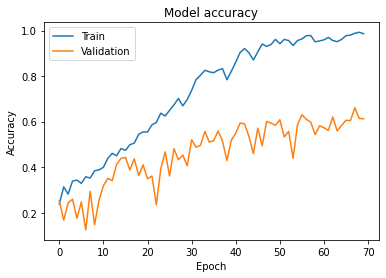

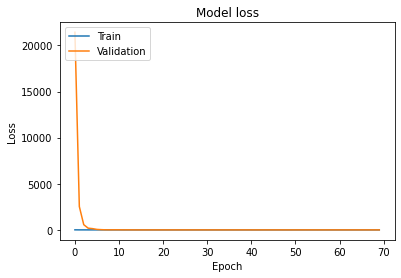

In [0]:
display_results(model1, model1_history)

## Change lr from 0.001 to 0.0001

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model2 = build_cnn1(optimizer)
model2_history = train(model2, batch_size=64, epochs=70)

50/50 [==============================] - 1s 17ms/step - loss: 3.9725e-04 - accuracy: 1.0000
Train dataset accuracy: 100.00%
16/16 [==============================] - 0s 16ms/step - loss: 0.9430 - accuracy: 0.7327
Validation dataset accuracy: 73.27%
12/12 [==============================] - 0s 16ms/step - loss: 0.9117 - accuracy: 0.7696
Test dataset accuracy: 76.96%


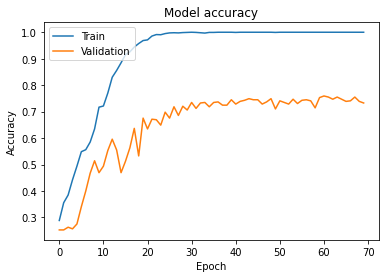

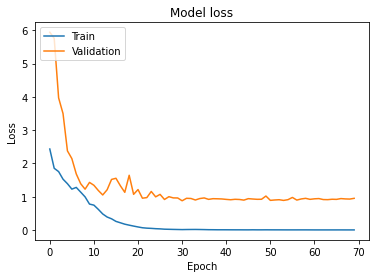

In [0]:
display_results(model2, model2_history)

## Third attempt - increate the number of convolutions

In [0]:
def build_cnn2(optimizer, l2=None):
    with strategy.scope():
        model = Sequential()
        model.add(Conv2D(512, (5, 5), padding='same', kernel_regularizer=l2,
                        input_shape=model_input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(512, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D())

        model.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D())

        model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(7))
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
        return model

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model3 = build_cnn2(optimizer)
model3_history = train(model3, batch_size=64, epochs=70)

50/50 [==============================] - 3s 58ms/step - loss: 3.7007e-04 - accuracy: 1.0000
Train dataset accuracy: 100.00%
16/16 [==============================] - 1s 62ms/step - loss: 0.6723 - accuracy: 0.8143
Validation dataset accuracy: 81.43%
12/12 [==============================] - 1s 81ms/step - loss: 0.7183 - accuracy: 0.8157
Test dataset accuracy: 81.57%


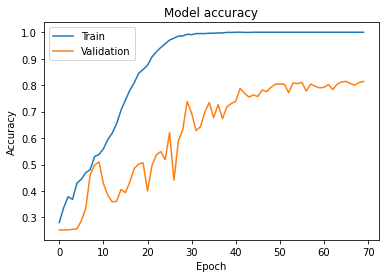

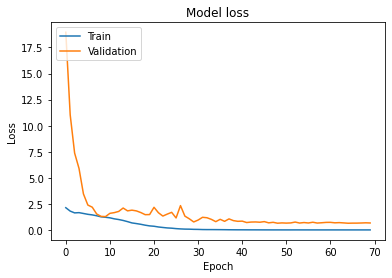

In [0]:
display_results(model3, model3_history)

## Add l2 regularization

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
#l2_regularizer = tf.keras.regularizers.l2(0.0001)
model4 = build_cnn2(optimizer, l2=l2_regularizer)
model4_history = train(model4, batch_size=64, epochs=70)

50/50 [==============================] - 2s 46ms/step - loss: 0.1582 - accuracy: 1.0000
Train dataset accuracy: 100.00%
16/16 [==============================] - 1s 42ms/step - loss: 0.9715 - accuracy: 0.6796
Validation dataset accuracy: 67.96%
12/12 [==============================] - 1s 43ms/step - loss: 1.0231 - accuracy: 0.6938
Test dataset accuracy: 69.38%


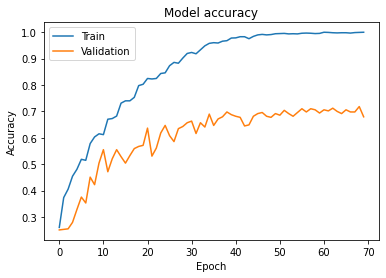

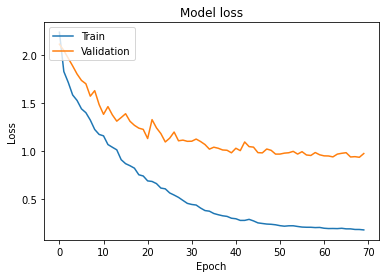

In [0]:
display_results(model4, model4_history)